In [4]:
import pandas as pd
import os
from bumblebee import BumblebeeClient
from amphibian.amphibian import get_data_accessor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [5]:
# get the Amphibian Data Accessor (ada)
ada = get_data_accessor(engines=["presto", "glitter"])

In [3]:
period = ada.fetch_sql(
sql = """
with starting as (

select
    a.client_id,
    cast(b.start_date as date) as period_start_date,
    b.client_state_detail as period_start_client_state_detail
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
--     and f.fiscal_year >= 2021
where b.client_state_detail in ('manual','autoship')

),

lapsed as (

select
    a.client_id,
    cast(b.start_date as date) as lapsed_start_date,
    case when a.client_state_detail = 'autoship' then 'former autoship'
         when a.client_state_detail = 'manual' then 'former manual'
         else 'unknown'
         end as lapsed_reason
--     cast(a.start_date as date) as pre_lapsed_start_date this doesn't work the proper way
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where b.client_state_detail = 'lapsed'
and a.client_state_detail in ('autoship','manual')
-- and a.client_id = 31123798
-- and a.client_id = 32206215
),

post_lapsed as (

select
    a.client_id,
    b.client_state_detail as post_lapsed_client_state_detail,
    cast(b.start_date as date) as post_lapsed_start_date
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where a.client_state_detail = 'lapsed'

),

period_start as (

select
    lapsed.client_id,
    starting.period_start_date,
    starting.period_start_client_state_detail,
    lapsed.lapsed_start_date,
    rank() over (partition by lapsed.client_id, lapsed.lapsed_start_date order by starting.period_start_date desc) as rank
from lapsed
left join starting
    on lapsed.client_id = starting.client_id
    and starting.period_start_date < lapsed.lapsed_start_date

),

period_end as (

select
    lapsed.client_id,
    lapsed.lapsed_start_date,
    post_lapsed.post_lapsed_start_date,
    post_lapsed.post_lapsed_client_state_detail,
    rank() over (partition by lapsed.client_id, lapsed.lapsed_start_date order by post_lapsed.post_lapsed_start_date) as rank
from lapsed
left join post_lapsed
    on lapsed.client_id = post_lapsed.client_id
    and (lapsed.lapsed_start_date < post_lapsed.post_lapsed_start_date or post_lapsed.post_lapsed_start_date is null)

)

select
    period_start.client_id,
    period_start.period_start_date,
    period_start.period_start_client_state_detail,   -- starting state the client was on
    period_start.lapsed_start_date,
    period_end.post_lapsed_start_date,
    period_end.post_lapsed_client_state_detail,
    date_diff('month',period_start.period_start_date,period_start.lapsed_start_date) as months_before_lapsed
from period_start
left join period_end
    on period_start.client_id = period_end.client_id
    and period_start.lapsed_start_date = period_end.lapsed_start_date
    and period_end.rank = 1
where period_start.rank = 1


""")

In [56]:
dorm_period = ada.fetch_sql(
sql = """
with starting as (

select
    a.client_id,
    cast(b.start_date as date) as period_start_date,
    b.client_state_detail as period_start_client_state_detail
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
--     and f.fiscal_year >= 2021
where b.client_state_detail in ('lapsed')
-- and a.client_id = 31123798
-- and a.client_id = 32206215

),

dormant as (

select
    a.client_id,
    cast(b.start_date as date) as dormant_start_date
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where b.client_state_detail = 'dormant'
and a.client_state_detail in ('lapsed')
-- and a.client_id = 31123798
-- and a.client_id = 32206215
),

post_dormant as (

select
    a.client_id,
    b.client_state_detail as post_dormant_client_state_detail,
    cast(b.start_date as date) as post_dormant_start_date
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where a.client_state_detail = 'dormant'
-- and a.client_id = 31123798
-- and a.client_id = 32206215
),

period_start as (

select
    dormant.client_id,
    starting.period_start_date,
    starting.period_start_client_state_detail,
    dormant.dormant_start_date,
    rank() over (partition by dormant.client_id, dormant.dormant_start_date order by starting.period_start_date desc) as rank
from dormant
left join starting
    on dormant.client_id = starting.client_id
    and starting.period_start_date < dormant.dormant_start_date

),

period_end as (

select
    dormant.client_id,
    dormant.dormant_start_date,
    post_dormant.post_dormant_start_date,
    post_dormant.post_dormant_client_state_detail,
    rank() over (partition by dormant.client_id, dormant.dormant_start_date order by post_dormant.post_dormant_start_date) as rank
from dormant
left join post_dormant
    on dormant.client_id = post_dormant.client_id
    and (dormant.dormant_start_date < post_dormant.post_dormant_start_date or post_dormant.post_dormant_start_date is null)

)

select
    period_start.client_id,
    period_start.period_start_date,
    period_start.period_start_client_state_detail,   -- starting state the client was on
    period_start.dormant_start_date,
    period_end.post_dormant_start_date,
    period_end.post_dormant_client_state_detail
from period_start
left join period_end
    on period_start.client_id = period_end.client_id
    and period_start.dormant_start_date = period_end.dormant_start_date
    and period_end.rank = 1
where period_start.rank = 1
-- and period_start.client_id = 5260777



"""
)

In [ ]:
gen = ada.fetch_sql(
sql ="""
with starting as (

select
    a.client_id,
    cast(b.start_date as date) as period_start_date,
    b.client_state_detail as period_start_client_state_detail
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
--     and f.fiscal_year >= 2021
where b.client_state_detail in ('manual','autoship')
-- and a.client_id in (6775636, 31123798,32206215)
),

lapsed as (

select
    a.client_id,
    cast(b.start_date as date) as lapsed_start_date
--     a.client_state_detail as pre_lapsed_client_state_detail
--     cast(a.start_date as date) as pre_lapsed_start_date this doesn't work the proper way
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where b.client_state_detail = 'lapsed'
and a.client_state_detail in ('autoship','manual')
-- and a.client_id in (6775636, 31123798,32206215)

),

period_start as (

select
    lapsed.client_id,
--     lapsed.pre_lapsed_client_state_detail,
    starting.period_start_date,
    starting.period_start_client_state_detail,
    lapsed.lapsed_start_date,
    rank() over (partition by lapsed.client_id, lapsed.lapsed_start_date order by starting.period_start_date desc) as rank
from lapsed
left join starting
    on lapsed.client_id = starting.client_id
    and starting.period_start_date < lapsed.lapsed_start_date

),

base as (

select
    client_id,
    period_start_date,
    period_start_client_state_detail,
    lapsed_start_date
from period_start
where rank = 1

),

res as (

select
    base.client_id,
    base.lapsed_start_date,
    count(distinct cr.reservation_id) as reservations_created,
    count(distinct case when cr.cancelled_at is not null then cr.reservation_id else null end) as reservations_cancelled
from base
inner join prod.clean_reservations as cr
    on base.client_id = cr.client_id
    and base.period_start_date <= cast(cr.created_at as date)
    and cast(cr.created_at as date) <= base.lapsed_start_date
group by 1,2

),

preview as (

select
    base.client_id,
    base.lapsed_start_date,
    count(distinct case when fpjv.opened_ts is not null then fpjv.fix_preview_id else null end) as previews_opened,
    count(distinct fpjv.fix_preview_id) as previews_created,
    round(100*(count(distinct case when fpjv.opened_ts is not null then fpjv.fix_preview_id else null end)/cast(count(distinct fpjv.fix_preview_id) as double)),1) as preview_open_rate,
    round(100*(sum(fpjv.n_items_selected)/cast(sum(fpjv.n_items_shown) as double)),1) as preview_item_selection_rate
from base
inner join curated.fix_preview_journal__view as fpjv
    on base.client_id = fpjv.client_id
    and base.period_start_date <= cast(fpjv.start_date as date)
    and cast(fpjv.start_date as date) <= base.lapsed_start_date
group by 1,2

),

orders as (

select
    base.client_id,
    base.lapsed_start_date,
    count(distinct buyable.direct_buy_order_id) as freestyle_orders,
    count(distinct buyable.shipment_id) as fix_orders,
    round(100*(sum(case when buyable.buyable_type = 'shipment' then buyable.items_sold else null end)/cast(sum(case when buyable.buyable_type = 'shipment' then buyable.items_sent else null end) as double)),1) as fix_keep_rate,
    round(100*(sum(case when buyable.buyable_type = 'direct_buy' then buyable.items_sold else null end)/cast(sum(case when buyable.buyable_type = 'direct_buy' then buyable.items_sent else null end) as double)),1) as freestyle_keep_rate
from base
inner join curated.buyable
    on base.client_id = buyable.client_id
    and base.period_start_date <= cast(buyable.created_ts as date)
    and cast(buyable.created_ts as date) <= base.lapsed_start_date
where cast(buyable.shipped_ts as date) is not null
group by 1,2

),

fix_cancel as (

select
    base.client_id,
    base.lapsed_start_date,
    count(distinct buyable.direct_buy_order_id) as cancelled_freestyle_orders,
    count(distinct buyable.shipment_id) as cancelled_fix_orders
from base
inner join curated.buyable
    on base.client_id = buyable.client_id
    and base.period_start_date <= cast(buyable.created_ts as date)
    and cast(buyable.created_ts as date) <= base.lapsed_start_date
where buyable.status = 'Cancelled'
group by 1,2

),

tenure as (

select
    base.client_id,
    base.lapsed_start_date,
    count(distinct buyable.direct_buy_order_id) as freestyle_tenure,
    count(distinct buyable.shipment_id) as fix_tenure
from base
inner join curated.buyable
    on base.client_id = buyable.client_id
    and cast(buyable.created_ts as date) <= base.lapsed_start_date
where cast(buyable.shipped_ts as date) is not null
group by 1,2

)

select
    base.client_id,
--     base.pre_lapsed_client_state_detail, --state before client went lapsed
    base.period_start_date,
    base.period_start_client_state_detail,
    base.lapsed_start_date,
    acr.survey_reason,
    client.business_line,
    client.client_price_pref_bucket,
    attr.signup_channel,
    case when attr.signup_channel in  ('Direct','Email','Organic Search','Referrals','Unknown','App','Other','Earned', 'InviteReferrals') then 'non-paid'
         else 'paid'
         end as signup_channel_paid_nonpaid,
    coalesce(res.reservations_created,0) as reservations_created,
    coalesce(res.reservations_cancelled,0) as reservations_cancelled,
    coalesce(preview.previews_opened,0) as previews_opened,
    coalesce(preview.previews_created,0) as previews_created,
    preview.preview_open_rate,
    preview.preview_item_selection_rate,
    coalesce(orders.freestyle_orders,0) as freestyle_orders,
    coalesce(orders.fix_orders,0) as fix_orders,
    orders.fix_keep_rate,
    orders.freestyle_keep_rate,
    coalesce(fix_cancel.cancelled_freestyle_orders,0) as cancelled_freestyle_orders,
    coalesce(fix_cancel.cancelled_fix_orders,0) as cancelled_fix_orders,
    coalesce(tenure.freestyle_tenure,0) as freestyle_tenure,
    coalesce(tenure.fix_tenure,0) as fix_tenure
from base
left join curated.client
    on base.client_id = client.client_id
left join curated.ga_af_attribution as attr
    on base.client_id = attr.client_id
left join prod.autoship_churn_reason as acr
    on base.client_id = acr.client_id
    and base.lapsed_start_date = acr.churn_date
left join res
    on base.client_id = res.client_id
    and base.lapsed_start_date = res.lapsed_start_date
left join preview
    on base.client_id = preview.client_id
    and base.lapsed_start_date = preview.lapsed_start_date
left join orders
    on base.client_id = orders.client_id
    and base.lapsed_start_date = orders.lapsed_start_date
left join fix_cancel
    on base.client_id = fix_cancel.client_id
    and base.lapsed_start_date = fix_cancel.lapsed_start_date
left join tenure
    on base.client_id = tenure.client_id
    and base.lapsed_start_date = tenure.lapsed_start_date


"""
)

In [9]:
ship = ada.fetch_sql(
sql="""
with base as (

select
    a.client_id,
    cast(b.start_date as date) as lapsed_start_date
--     a.client_state_detail as pre_lapsed_client_state_detail
--     cast(a.start_date as date) as pre_lapsed_start_date this doesn't work the proper way
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where b.client_state_detail = 'lapsed'
and a.client_state_detail in ('autoship','manual')
-- and a.client_id in (6775636, 31123798,32206215)

),

last_order_base as (

select
    base.client_id,
    base.lapsed_start_date,
    max(buyable.created_ts) as last_created_ts
from base
left join curated.buyable
    on base.client_id = buyable.client_id
    and cast(buyable.created_ts as date) <= base.lapsed_start_date
group by 1,2

),

last_order as (

select
    last_order_base.client_id,
    last_order_base.lapsed_start_date,
    buyable.buyable_type as last_order_buyable_type,
    buyable.created_ts as last_order_created_at,
    buyable.shipped_ts as last_order_shipped_at,
    buyable.checkout_ts as last_order_checkout_at,
    buyable.status as last_order_status,
    buyable.items_sent as last_order_items_sent,
    buyable.items_sold as last_order_items_sold,
    sjv.created_with_autoship_flag as last_order_created_with_autoship_flag,
    case when fpj.opened_ts is not null then 1 else 0 end as last_order_opened_fix_preview,
    round(100*(fpj.n_items_selected/cast(fpj.n_items_shown as double)),1) as last_order_fix_preview_selection_rate,
    fpj.preview_type as last_order_fix_preview_type
from last_order_base
inner join curated.buyable
    on last_order_base.client_id = buyable.client_id
    and last_order_base.last_created_ts = buyable.created_ts
left join curated.shipment_journal__view as sjv
    on buyable.shipment_id = sjv.shipment_id
left join curated.fix_preview_journal__view as fpj
    on buyable.shipment_id = fpj.shipment_id

),

last_uncancelled_order_base as (

select
    base.client_id,
    base.lapsed_start_date,
    max(buyable.created_ts) as last_created_ts
from base
left join curated.buyable
    on base.client_id = buyable.client_id
    and cast(buyable.created_ts as date) <= base.lapsed_start_date
    and buyable.shipped_ts is not null
group by 1,2

),

last_uncancelled_order as (

select
    luob.client_id,
    luob.lapsed_start_date,
    buyable.buyable_type as luo_buyable_type,
    buyable.created_ts as luo_created_at,
    buyable.shipped_ts as luo_shipped_at,
    buyable.checkout_ts as luo_checkout_at,
    buyable.status as luo_status,
    buyable.items_sent as luo_items_sent,
    buyable.items_sold as luo_items_sold,
    sjv.created_with_autoship_flag as luo_created_with_autoship_flag,
    case when fpj.opened_ts is not null then 1 else 0 end as luo_opened_fix_preview,
    round(100*(fpj.n_items_selected/cast(fpj.n_items_shown as double)),1) as luo_fix_preview_selection_rate,
    fpj.preview_type as luo_fix_preview_type
from last_uncancelled_order_base as luob
inner join curated.buyable
    on luob.client_id = buyable.client_id
    and luob.last_created_ts = buyable.created_ts
left join curated.shipment_journal__view as sjv
    on buyable.shipment_id = sjv.shipment_id
left join curated.fix_preview_journal__view as fpj
    on buyable.shipment_id = fpj.shipment_id

)

select
    base.client_id,
    base.lapsed_start_date,
    last_order_buyable_type,
    last_order.last_order_created_at,
    last_order.last_order_shipped_at,
    last_order.last_order_checkout_at,
    last_order.last_order_status,
    last_order.last_order_items_sent,
    last_order.last_order_items_sold,
    last_order.last_order_created_with_autoship_flag,
    last_order.last_order_opened_fix_preview,
    last_order.last_order_fix_preview_selection_rate,
    last_order.last_order_fix_preview_type,
    luo.luo_buyable_type,
    luo.luo_created_at,
    luo.luo_shipped_at,
    luo.luo_checkout_at,
    luo.luo_status,
    luo.luo_items_sent,
    luo.luo_items_sold,
    luo.luo_created_with_autoship_flag,
    luo.luo_opened_fix_preview,
    luo.luo_fix_preview_selection_rate,
    luo.luo_fix_preview_type
from base
left join last_order
    on base.client_id = last_order.client_id
    and base.lapsed_start_date = last_order.lapsed_start_date
left join last_uncancelled_order as luo
    on base.client_id = luo.client_id
    and base.lapsed_start_date = luo.lapsed_start_date




"""
)

In [15]:
#period_df = period.copy()
period['post_lapsed_client_state_detail'] = np.where(
            period['post_lapsed_client_state_detail'] == "dormant", "dormant", np.where(
            period['post_lapsed_client_state_detail'] == "manual", "manual", np.where(
            period['post_lapsed_client_state_detail'] == "autoship","autoship",np.where(
            period['post_lapsed_client_state_detail'].isnull() == True,"unchanged",
                "other"))))

In [32]:
df = period.merge(gen, how = "inner", left_on = ["client_id","lapsed_start_date"], right_on = ["client_id","lapsed_start_date"], suffixes=('_left', '') )


NameError: name 'gen' is not defined

In [62]:
def reason_segments(df, column, show_known_outcomes = "no"):
    if show_known_outcomes == "no":
        from_order = df[df["period_start_client_state_detail"] == "manual"][column].value_counts().to_frame().reset_index()
        from_order['percent_of_total'] = (100*(from_order[column] / from_order[column].sum())).round(1)

        from_order.rename(columns = {column:"num_instances",
                                     "index":column},inplace = True)
        from_order['previous_state'] = 'manual'


        from_autoship = df[df["period_start_client_state_detail"] == "autoship"][column].value_counts().to_frame().reset_index()
        from_autoship['percent_of_total'] = (100*(from_autoship[column] / from_autoship[column].sum())).round(1)

        from_autoship.rename(columns = {column:"num_instances",
                                     "index":column},inplace = True)
        from_autoship['previous_state'] = 'autoship'

        stack_df = pd.concat([from_autoship,from_order]).reset_index(drop = True)
    else:
        from_order = df[(df["period_start_client_state_detail"] == "manual") & (df["post_lapsed_client_state_detail"] != "unchanged")][column].value_counts().to_frame().reset_index()
        from_order['percent_of_total'] = (100*(from_order[column] / from_order[column].sum())).round(1)

        from_order.rename(columns = {column:"num_instances",
                                     "index":column},inplace = True)
        from_order['previous_state'] = 'manual'


        from_autoship = df[(df["period_start_client_state_detail"] == "autoship") & (df["post_lapsed_client_state_detail"] != "unchanged")][column].value_counts().to_frame().reset_index()
        from_autoship['percent_of_total'] = (100*(from_autoship[column] / from_autoship[column].sum())).round(1)

        from_autoship.rename(columns = {column:"num_instances",
                                     "index":column},inplace = True)
        from_autoship['previous_state'] = 'autoship'

        stack_df = pd.concat([from_autoship,from_order]).reset_index(drop = True)
        
    return stack_df

<h3> Previous State Distribution </h3>

Text(0.5, 1.0, 'Percent of Lapsed Clients by Previous Client State for FY21-SepFY23')

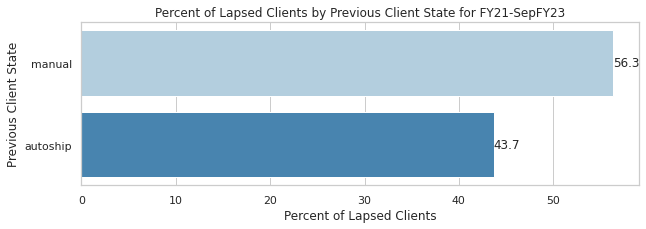

In [66]:
reason = period["period_start_client_state_detail"].value_counts().to_frame()
reason.rename(columns={"period_start_client_state_detail": "num_instances"}, inplace = True)
reason["percent_of_total"] = (100*(reason["num_instances"] / reason["num_instances"].sum())).round(1)
reason.reset_index(inplace = True)

plt.figure(figsize = (10,3))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
ax = sns.barplot(data = reason,
            y = "index",
            x = "percent_of_total",
            palette = "Blues")
for i in ax.containers:
    ax.bar_label(i,)
plt.ylabel("Previous Client State")
plt.xlabel("Percent of Lapsed Clients")
plt.title("Percent of Lapsed Clients by Previous Client State for FY21-SepFY23")

<h3> Following State Distribution </h3>

<ipython-input-61-df28bbf9ca5b>:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Percent of Lapsed Clients by Post-Lapsed State for FY21-SepFY23')

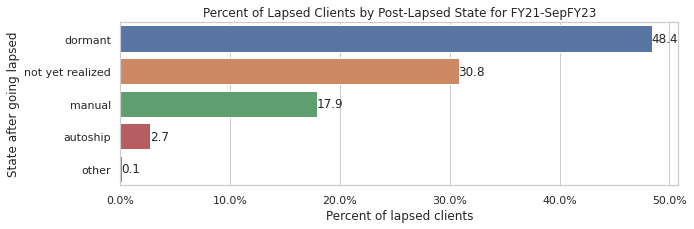

In [61]:
#post lapsed state
pl_state = period["post_lapsed_client_state_detail"].value_counts().to_frame()
pl_state.reset_index(inplace = True)
pl_state.rename(columns={"post_lapsed_client_state_detail":"num_instances",
                        "index":"state"}, inplace = True)
pl_state["percent_of_total"] = (100*(pl_state["num_instances"] / pl_state["num_instances"].sum())).round(1)

plt.figure(figsize = (10,3))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

ax = sns.barplot(data = pl_state,
            y = "state",
            x = "percent_of_total",
            )
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_xticklabels(['{0}%'.format(x) for x in ax.get_xticks()])
plt.xlabel("Percent of lapsed clients")
plt.ylabel("State after going lapsed")
plt.title("Percent of Lapsed Clients by Post-Lapsed State for FY21-SepFY23")

<ipython-input-65-188fde822f0a>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Percent of Lapsed Clients by Known Post-Lapsed State for FY21-SepFY23')

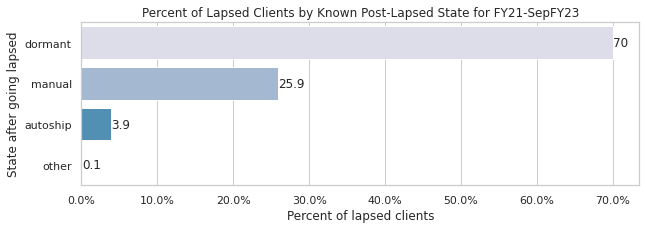

In [65]:
#post lapsed state
pl_state = period[period["post_lapsed_client_state_detail"] != "not yet realized"]["post_lapsed_client_state_detail"].value_counts().to_frame()
pl_state.reset_index(inplace = True)
pl_state.rename(columns={"post_lapsed_client_state_detail":"num_instances",
                        "index":"state"}, inplace = True)
pl_state["percent_of_total"] = (100*(pl_state["num_instances"] / pl_state["num_instances"].sum())).round(1)

plt.figure(figsize = (10,3))
ax = sns.barplot(data = pl_state,
            y = "state",
            x = "percent_of_total",
            palette = "PuBu"
            )
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_xticklabels(['{0}%'.format(x) for x in ax.get_xticks()])
plt.xlabel("Percent of lapsed clients")
plt.ylabel("State after going lapsed")
plt.title("Percent of Lapsed Clients by Known Post-Lapsed State for FY21-SepFY23")

<h3> Autoship Tenure Distribution </h3>

<ipython-input-120-f29f14b32650>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Months on Autoship Distribution')

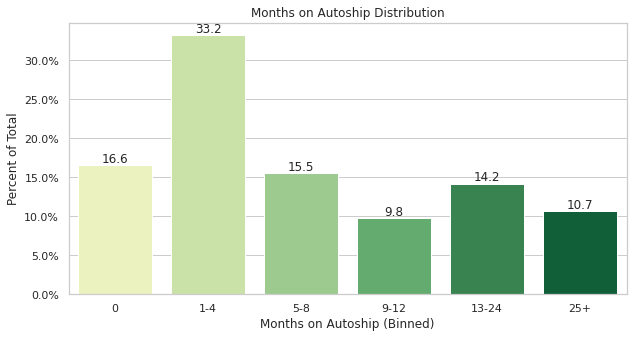

In [120]:
autoship_dist = period[period["period_start_client_state_detail"] == "autoship"]["months_before_lapsed"].value_counts().to_frame().reset_index()
autoship_dist.rename(columns={"index": "month", "months_before_lapsed": "num_instances"},inplace = True)

bins = [-1,0,4,8,12,24,110]
labels = ["0","1-4","5-8","9-12","13-24","25+"]
autoship_dist["bin"] = pd.cut(autoship_dist['month'], bins = bins, labels = labels)

bin_df = autoship_dist.groupby("bin")["num_instances"].sum().reset_index()
bin_df["percent_of_total"] = (100*(bin_df["num_instances"] / bin_df["num_instances"].sum())).round(1)

plt.figure(figsize = (10,5))
ax = sns.barplot(data = bin_df, x="bin",y="percent_of_total", palette = "YlGn")

ax.set_yticklabels(['{0}%'.format(y) for y in ax.get_yticks()])
for i in ax.containers:
    ax.bar_label(i,)
    
plt.ylabel("Percent of Total")
plt.xlabel("Months on Autoship (Binned)")
plt.title("Months on Autoship Distribution")

<ipython-input-63-2422e85bfcdc>:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



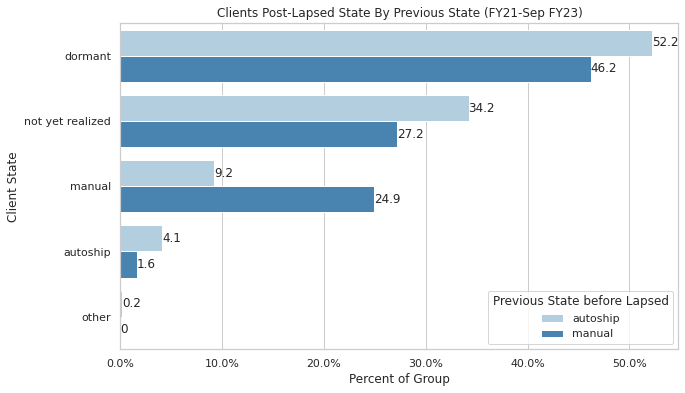

In [63]:
status_seg = reason_segments(df, "post_lapsed_client_state_detail")

plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")


ax = sns.barplot(data = status_seg,
                 y = "post_lapsed_client_state_detail",
                 x = "percent_of_total",
                 hue = "previous_state",
                 palette = "Blues"
                )
    
plt.ylabel("Client State")
plt.xlabel("Percent of Group")
plt.title("Clients Post-Lapsed State By Previous State (FY21-Sep FY23)")
plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)

ax.set_xticklabels(['{0}%'.format(x) for x in ax.get_xticks()])
sns.move_legend(ax, "lower right")

<ipython-input-37-6752b6d24e9a>:23: UserWarning:

FixedFormatter should only be used together with FixedLocator



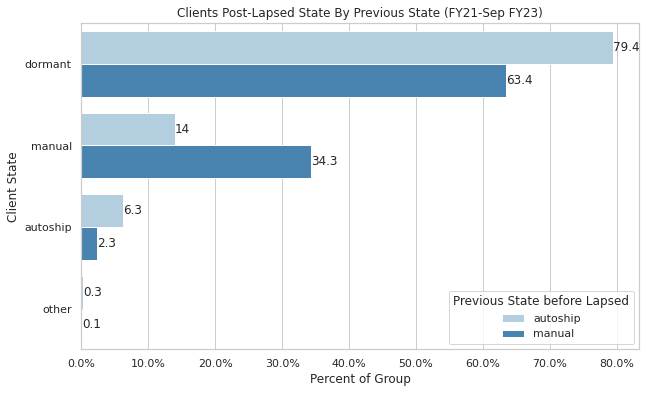

In [37]:
status_seg = reason_segments(df, "post_lapsed_client_state_detail", show_known_outcomes = "yes")

plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")


ax = sns.barplot(data = status_seg,
                 y = "post_lapsed_client_state_detail",
                 x = "percent_of_total",
                 hue = "previous_state",
                 palette = "Blues"
                )
    
plt.ylabel("Client State")
plt.xlabel("Percent of Group")
plt.title("Clients Post-Lapsed State By Previous State (FY21-Sep FY23)")
plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)

ax.set_xticklabels(['{0}%'.format(x) for x in ax.get_xticks()])
sns.move_legend(ax, "lower right")

<ipython-input-34-46842e9da71a>:29: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0, '1-3'), Text(1, 0, '4-7'), Text(2, 0, '8+')]

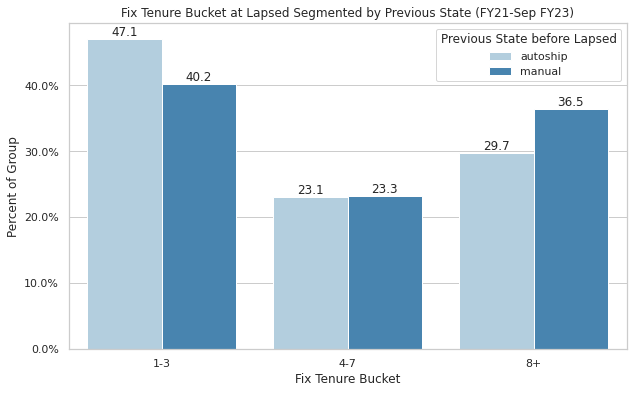

In [34]:
#df['sales'] / df.groupby('state')['sales'].transform('sum')
tenure_dist = df.groupby(["period_start_client_state_detail","fix_tenure"])['client_id'].count().to_frame().reset_index()
tenure_dist["fix_tenure_bucket"] = np.where(
            tenure_dist['fix_tenure'].astype(int) < 4, 1, np.where(
            tenure_dist['fix_tenure'].astype(int) < 8, 4, 8
            ))
tenure_bin = tenure_dist.groupby(["period_start_client_state_detail", "fix_tenure_bucket"])["client_id"].sum().reset_index()
tenure_bin.rename(columns={"client_id":"num_instances"},inplace = True)
tenure_bin["percent_of_group"] = (100*(tenure_bin['num_instances'] / tenure_bin.groupby('period_start_client_state_detail')['num_instances'].transform('sum'))).round(1)

plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
ax = sns.barplot(data = tenure_bin,
                 x = "fix_tenure_bucket",
                 y = "percent_of_group",
                 hue = "period_start_client_state_detail",
                 palette = "Blues"
                )

plt.xlabel("Fix Tenure Bucket")
plt.ylabel("Percent of Group")
plt.title("Fix Tenure Bucket at Lapsed Segmented by Previous State (FY21-Sep FY23)")
plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)

ax.set_yticklabels(['{0}%'.format(x) for x in ax.get_yticks()])

ax.set_xticklabels(['1-3','4-7','8+'])

<ipython-input-36-29108cf2c48f>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



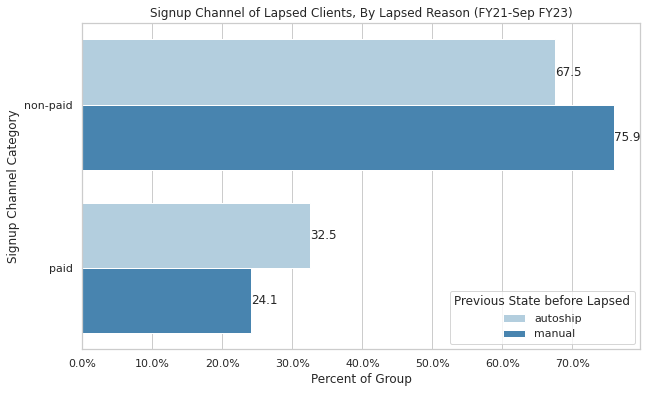

In [36]:
channel = reason_segments(df, "signup_channel_paid_nonpaid")

plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")


ax = sns.barplot(data = channel,
                 y = "signup_channel_paid_nonpaid",
                 x = "percent_of_total",
                 hue = "previous_state",
                 palette = "Blues"
                )
    
plt.ylabel("Signup Channel Category")
plt.xlabel("Percent of Group")
plt.title("Signup Channel of Lapsed Clients By Previous State (FY21-Sep FY23)")
plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)

vals = ax.get_xticks()
ax.set_xticklabels(['{0}%'.format(x) for x in vals])
sns.move_legend(ax, "lower right")

<ipython-input-46-f7c4cdf48826>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



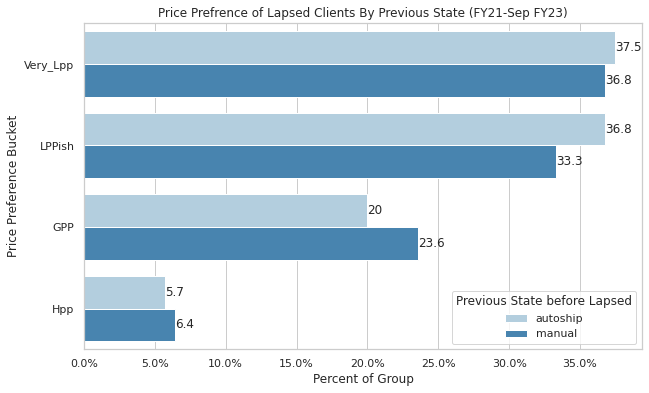

In [46]:
price = reason_segments(df, "client_price_pref_bucket")

plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")


ax = sns.barplot(data = price,
                 y = "client_price_pref_bucket",
                 x = "percent_of_total",
                 hue = "previous_state",
                 palette = "Blues"
                )
    
plt.ylabel("Price Preference Bucket")
plt.xlabel("Percent of Group")
plt.title("Price Prefrence of Lapsed Clients By Previous State (FY21-Sep FY23)")
plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)

vals = ax.get_xticks()
ax.set_xticklabels(['{0}%'.format(x) for x in vals])
sns.move_legend(ax, "lower right")

In [31]:
df.columns

NameError: name 'df' is not defined

In [42]:
df.head()

,client_id,period_start_date_left,period_start_client_state_detail_left,lapsed_start_date,post_lapsed_start_date,post_lapsed_client_state_detail,months_before_lapsed,period_start_date,period_start_client_state_detail,survey_reason,...,preview_open_rate,preview_item_selection_rate,freestyle_orders,fix_orders,fix_keep_rate,freestyle_keep_rate,cancelled_freestyle_orders,cancelled_fix_orders,freestyle_tenure,fix_tenure
0,34061496,2021-06-03,manual,2021-10-02,2022-06-04,dormant,3.0,2021-06-03,manual,None,...,NaN,NaN,0,1,30.0,None,0,0,0,2
1,32017771,2020-09-18,autoship,2021-07-30,2021-09-29,dormant,10.0,2020-09-18,autoship,None,...,NaN,NaN,0,1,40.0,None,0,4,0,2
2,29117054,2020-04-16,autoship,2020-09-03,2021-08-20,dormant,4.0,2020-04-16,autoship,cannot_afford,...,NaN,NaN,0,3,86.7,None,0,0,0,4
3,40263364,2022-05-12,autoship,2022-07-31,2022-09-14,manual,2.0,2022-05-12,autoship,not_my_style,...,100.0,12.5,0,2,40.0,None,0,1,0,3
4,28346461,2022-03-01,manual,2022-06-29,None,not yet realized,3.0,2022-03-01,manual,None,...,NaN,NaN,0,0,NaN,None,0,0,0,1


In [5]:
gen.head()

NameError: name 'gen' is not defined

In [12]:
ship.head()

,client_id,lapsed_start_date,last_order_buyable_type,last_order_created_at,last_order_shipped_at,last_order_checkout_at,last_order_status,last_order_items_sent,last_order_items_sold,last_order_created_with_autoship_flag,...,luo_created_at,luo_shipped_at,luo_checkout_at,luo_status,luo_items_sent,luo_items_sold,luo_created_with_autoship_flag,luo_opened_fix_preview,luo_fix_preview_selection_rate,luo_fix_preview_type
0,10239195,2022-01-14,direct_buy,2021-09-16 00:17:49.407,2021-09-16 16:03:41.752,2021-09-16 00:17:49.407,Shipped,2.0,0.0,NaN,...,2021-09-16 00:17:49.407,2021-09-16 16:03:41.752,2021-09-16 00:17:49.407,Shipped,2.0,0.0,NaN,0.0,NaN,None
1,24947340,2022-07-16,shipment,2022-03-14 20:12:24.292,2022-03-18 16:52:23.520,2022-03-21 23:40:54.348,Processed,10.0,10.0,0.0,...,2022-03-14 20:12:24.292,2022-03-18 16:52:23.520,2022-03-21 23:40:54.348,Processed,10.0,10.0,0.0,0.0,NaN,None
2,16824761,2021-01-09,shipment,2020-08-31 07:46:32.678,2020-09-11 18:59:50.304,2020-09-16 23:56:37.643,Processed,5.0,1.0,0.0,...,2020-08-31 07:46:32.678,2020-09-11 18:59:50.304,2020-09-16 23:56:37.643,Processed,5.0,1.0,0.0,0.0,NaN,None
3,28669213,2022-01-14,shipment,2021-09-14 23:11:23.398,2021-09-16 20:45:07.570,2021-09-21 22:18:41.684,Processed,10.0,5.0,0.0,...,2021-09-14 23:11:23.398,2021-09-16 20:45:07.570,2021-09-21 22:18:41.684,Processed,10.0,5.0,0.0,0.0,NaN,None
4,18787905,2022-08-05,shipment,2022-03-30 20:17:54.795,2022-04-07 11:18:46.940,2022-04-12 23:45:59.200,Processed,10.0,6.0,0.0,...,2022-03-30 20:17:54.795,2022-04-07 11:18:46.940,2022-04-12 23:45:59.200,Processed,10.0,6.0,0.0,0.0,NaN,None


In [10]:
ship_df = period.merge(ship, how = "inner", left_on = ["client_id","lapsed_start_date"], right_on = ["client_id","lapsed_start_date"], suffixes=('_left', '') )
ship_df.head()

,client_id,period_start_date,period_start_client_state_detail,lapsed_start_date,post_lapsed_start_date,post_lapsed_client_state_detail,months_before_lapsed,last_order_buyable_type,last_order_created_at,last_order_shipped_at,...,luo_created_at,luo_shipped_at,luo_checkout_at,luo_status,luo_items_sent,luo_items_sold,luo_created_with_autoship_flag,luo_opened_fix_preview,luo_fix_preview_selection_rate,luo_fix_preview_type
0,40335600,2022-05-17,autoship,2022-06-07,None,None,0.0,shipment,2022-05-30 12:09:30.877,2022-06-03 15:04:58.966,...,2022-05-30 12:09:30.877,2022-06-03 15:04:58.966,2022-06-06 10:41:59.797,Processed,5.0,1.0,1.0,1.0,0.0,agp
1,22662376,2019-07-10,autoship,2020-08-05,2021-02-13,autoship,12.0,shipment,2020-06-26 07:57:13.986,2020-07-08 11:49:52.300,...,2020-06-26 07:57:13.986,2020-07-08 11:49:52.300,2020-08-04 21:27:18.703,Processed,5.0,1.0,1.0,0.0,NaN,None
2,25690930,2020-09-20,manual,2021-03-05,2021-05-06,manual,5.0,direct_buy,2020-11-05 18:09:57.799,2020-11-06 15:33:12.965,...,2020-11-05 18:09:57.799,2020-11-06 15:33:12.965,2020-11-05 18:09:57.799,Shipped,1.0,1.0,NaN,0.0,NaN,None
3,36147733,2021-08-09,manual,2021-12-02,2022-08-04,dormant,3.0,shipment,2021-08-08 03:12:38.375,None,...,2021-08-04 03:02:33.124,2021-08-05 16:36:09.657,2021-08-04 03:02:33.124,Shipped,1.0,0.0,NaN,0.0,NaN,None
4,4645120,2021-06-05,autoship,2021-10-26,None,None,4.0,shipment,2021-10-26 07:22:43.521,None,...,2021-10-05 07:18:19.677,2021-10-14 15:44:20.260,2021-10-18 13:14:30.029,Processed,5.0,2.0,1.0,1.0,10.0,hybrid_agp


In [13]:
ship_df[["client_id","period_start_date","period_start_client_state_detail", "lapsed_start_date",'last_order_created_at',
       'last_order_shipped_at', 'last_order_checkout_at','last_order_status',
       'last_order_items_sent', 'last_order_items_sold',
       'last_order_created_with_autoship_flag',
       'last_order_opened_fix_preview',
       'last_order_fix_preview_selection_rate', 'last_order_fix_preview_type']]

,client_id,period_start_date,period_start_client_state_detail,lapsed_start_date,last_order_created_at,last_order_shipped_at,last_order_checkout_at,last_order_status,last_order_items_sent,last_order_items_sold,last_order_created_with_autoship_flag,last_order_opened_fix_preview,last_order_fix_preview_selection_rate,last_order_fix_preview_type
0,33595552,2021-01-16,manual,2021-09-23,2021-05-15 07:53:17.912,2021-05-26 10:29:18.560,2021-06-02 19:04:35.811,Processed,5.0,0.0,0.0,1.0,0.0,stylist
1,22630067,2022-05-15,manual,2022-09-12,2022-05-15 22:56:09.858,2022-05-16 18:26:25.362,2022-05-15 22:56:09.858,Shipped,2.0,2.0,NaN,0.0,NaN,None
2,5377149,2021-11-17,autoship,2022-03-22,2022-03-04 09:42:35.756,2022-03-15 16:32:07.517,2022-03-22 12:21:36.293,Processed,5.0,2.0,1.0,1.0,40.0,agp
3,26503437,2021-03-24,manual,2021-12-16,2021-11-04 07:24:09.804,None,None,Cancelled,NaN,NaN,0.0,0.0,NaN,None
4,10390771,2022-01-09,autoship,2022-04-21,2022-04-16 08:42:42.442,None,None,Cancelled,NaN,NaN,1.0,0.0,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172770,15368354,2021-05-29,manual,2021-09-27,2021-05-30 01:22:41.024,2021-06-01 14:56:31.583,2021-05-30 01:22:41.024,Shipped,1.0,1.0,NaN,0.0,NaN,None
5172771,13154573,2022-05-21,manual,2022-09-19,2022-05-22 01:39:55.147,2022-05-22 18:18:15.228,2022-05-22 01:39:55.147,Shipped,1.0,1.0,NaN,0.0,NaN,None
5172772,33074882,2021-02-18,manual,2021-06-19,2021-02-01 08:41:42.936,2021-02-19 13:22:42.847,2021-03-09 14:04:09.173,Processed,5.0,1.0,1.0,0.0,NaN,None
5172773,6207521,2021-07-20,manual,2021-11-19,2021-07-20 17:08:37.687,2021-07-22 17:59:39.825,2021-07-26 18:20:37.501,Processed,5.0,5.0,0.0,1.0,40.0,agp


In [22]:
ship_df[['client_id','period_start_date','period_start_client_state_detail','lapsed_start_date','luo_buyable_type', 'luo_created_at', 'luo_shipped_at',
       'luo_checkout_at', 'luo_status', 'luo_items_sent', 'luo_items_sold',
       'luo_created_with_autoship_flag', 'luo_opened_fix_preview',
       'luo_fix_preview_selection_rate', 'luo_fix_preview_type']]

,client_id,period_start_date,period_start_client_state_detail,lapsed_start_date,luo_buyable_type,luo_created_at,luo_shipped_at,luo_checkout_at,luo_status,luo_items_sent,luo_items_sold,luo_created_with_autoship_flag,luo_opened_fix_preview,luo_fix_preview_selection_rate,luo_fix_preview_type
0,33595552,2021-01-16,manual,2021-09-23,shipment,2021-05-15 07:53:17.912,2021-05-26 10:29:18.560,2021-06-02 19:04:35.811,Processed,5.0,0.0,0.0,1.0,0.0,stylist
1,22630067,2022-05-15,manual,2022-09-12,direct_buy,2022-05-15 22:56:09.858,2022-05-16 18:26:25.362,2022-05-15 22:56:09.858,Shipped,2.0,2.0,NaN,0.0,NaN,None
2,5377149,2021-11-17,autoship,2022-03-22,shipment,2022-03-04 09:42:35.756,2022-03-15 16:32:07.517,2022-03-22 12:21:36.293,Processed,5.0,2.0,1.0,1.0,40.0,agp
3,26503437,2021-03-24,manual,2021-12-16,shipment,2021-08-06 07:31:37.746,2021-08-18 13:48:41.288,2021-08-24 19:31:09.458,Processed,10.0,10.0,0.0,0.0,NaN,None
4,10390771,2022-01-09,autoship,2022-04-21,shipment,2022-02-21 09:37:11.218,2022-03-02 17:18:59.142,2022-03-07 22:59:29.600,Processed,5.0,0.0,1.0,0.0,0.0,hybrid_agp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172770,15368354,2021-05-29,manual,2021-09-27,direct_buy,2021-05-30 01:22:41.024,2021-06-01 14:56:31.583,2021-05-30 01:22:41.024,Shipped,1.0,1.0,NaN,0.0,NaN,None
5172771,13154573,2022-05-21,manual,2022-09-19,direct_buy,2022-05-22 01:39:55.147,2022-05-22 18:18:15.228,2022-05-22 01:39:55.147,Shipped,1.0,1.0,NaN,0.0,NaN,None
5172772,33074882,2021-02-18,manual,2021-06-19,shipment,2021-02-01 08:41:42.936,2021-02-19 13:22:42.847,2021-03-09 14:04:09.173,Processed,5.0,1.0,1.0,0.0,NaN,None
5172773,6207521,2021-07-20,manual,2021-11-19,shipment,2021-07-20 17:08:37.687,2021-07-22 17:59:39.825,2021-07-26 18:20:37.501,Processed,5.0,5.0,0.0,1.0,40.0,agp


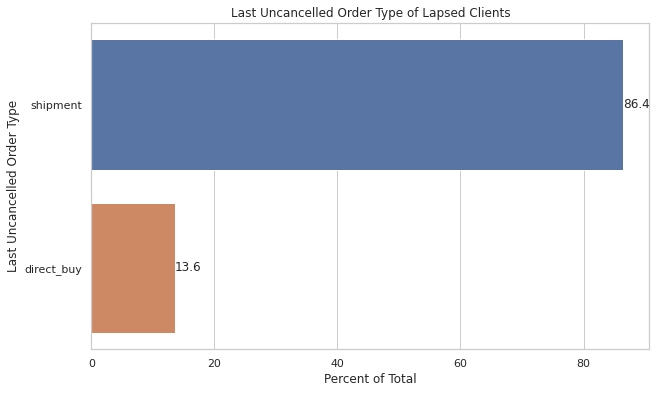

In [44]:
bt = ship_df["luo_buyable_type"].value_counts().reset_index()
bt.rename(columns = {"index":"luo_buyable_type",
                     "luo_buyable_type":"num_instances"},
          inplace = True)
bt["percent_of_total"] = (100*(bt["num_instances"] / bt["num_instances"].sum())).round(1)


plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

ax = sns.barplot(data = bt, y = "luo_buyable_type", x = "percent_of_total")

plt.ylabel("Last Uncancelled Order Type")
plt.xlabel("Percent of Total")
plt.title("Last Uncancelled Order Type of Lapsed Clients")
# plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)



In [26]:
luo_keep_rate = ship_df[(ship_df["luo_buyable_type"] == "shipment") & (ship_df["luo_items_sent"] == 5)][["luo_items_sent","luo_items_sold"]]
luo_keep_rate["keep_rate"] = luo_keep_rate["luo_items_sold"] / luo_keep_rate["luo_items_sent"]

lkr = luo_keep_rate["keep_rate"].value_counts().reset_index()
lkr["percent_of_total"] = (100*(lkr["keep_rate"] / lkr["keep_rate"].sum())).round(1)
lkr.rename(columns = {"keep_rate":"num_instances",
                      "index":"keep_rate"},
                      inplace = True)
lkr["keep_rate"] = 100*lkr["keep_rate"]
lkr

,keep_rate,num_instances,percent_of_total
0,0.0,1396362,36.5
1,100.0,842718,22.0
2,20.0,723347,18.9
3,40.0,516738,13.5
4,60.0,271148,7.1
5,80.0,75822,2.0


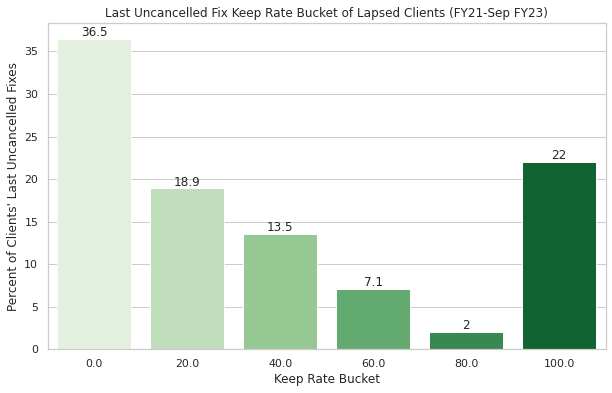

In [33]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
ax = sns.barplot(data = lkr, x = "keep_rate", y = "percent_of_total", palette = "Greens")

plt.ylabel("Percent of Clients' Last Uncancelled Fixes")
plt.xlabel("Keep Rate Bucket")
plt.title("Keep Rate Distribution of Lapsed Clients' Last Uncancelled Fix")
# plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)

vals = ax.get_xticks()
# ax.set_xticklabels(['{0.0}%'.format(x) for x in vals])
# sns.move_legend(ax, "lower right")

In [23]:
luo_keep_rate = ship_df[(ship_df["luo_buyable_type"] == "shipment") & (ship_df["luo_items_sent"] == 5)][["period_start_client_state_detail","luo_items_sent","luo_items_sold"]]
luo_keep_rate["keep_rate"] = luo_keep_rate["luo_items_sold"] / luo_keep_rate["luo_items_sent"]

grp_kr = luo_keep_rate.groupby(["period_start_client_state_detail", "keep_rate"]).size().reset_index()
grp_kr.rename(columns = {0:"num_instances"},inplace = True)
grp_kr["percent_of_client_state"] = (100*(grp_kr['num_instances'] / grp_kr.groupby('period_start_client_state_detail')['num_instances'].transform('sum'))).round(1)
grp_kr["keep_rate"] = 100*grp_kr["keep_rate"]


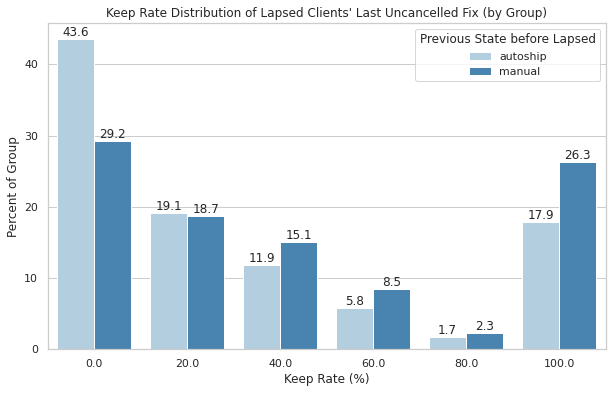

In [24]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

ax = sns.barplot(data = grp_kr, x = "keep_rate", y = "percent_of_client_state", hue = "period_start_client_state_detail", palette = "Blues")
plt.xlabel("Keep Rate (%)")
plt.ylabel("Percent of Group")
plt.title("Keep Rate Distribution of Lapsed Clients' Last Uncancelled Fix (by Group)")
plt.legend(title = "Previous State before Lapsed")

for i in ax.containers:
    ax.bar_label(i,)


In [11]:
ship_df["last_order_was_shipped"] = np.where(ship_df["last_order_shipped_at"].isna() == False, "yes","no")
last_order_agg = ship_df.groupby(["period_start_client_state_detail","last_order_was_shipped"]).size().reset_index()
last_order_agg["percent_of_group"] = last_order_agg['last_order_was_shipped']/last_order_agg.groupby('period_start_client_state_detail')['last_order_was_shipped'].transform('sum')
last_order_agg

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [21]:
luo_keep_rate = ship_df[(ship_df["luo_buyable_type"] == "shipment") & (ship_df["period_start_client_state_detail"] == "autoship") & (ship_df["luo_items_sent"] == 5)][["post_lapsed_client_state_detail","luo_items_sent","luo_items_sold"]]
luo_keep_rate["keep_rate"] = luo_keep_rate["luo_items_sold"] / luo_keep_rate["luo_items_sent"]

grp_kr = luo_keep_rate.groupby(["post_lapsed_client_state_detail", "keep_rate"]).size().reset_index()
grp_kr.rename(columns = {0:"num_instances"},inplace = True)
grp_kr["percent_of_client_state"] = (100*(grp_kr['num_instances'] / grp_kr['num_instances'].sum())).round(1)
grp_kr["keep_rate"] = 100*grp_kr["keep_rate"]
grp_kr

,post_lapsed_client_state_detail,keep_rate,num_instances,percent_of_client_state
0,all_cancelled,0.0,4,0.0
1,all_cancelled,20.0,2,0.0
2,all_cancelled,60.0,2,0.0
3,all_cancelled,100.0,4,0.0
4,autoship,0.0,23544,1.9
5,autoship,20.0,15942,1.3
6,autoship,40.0,12456,1.0
7,autoship,60.0,7207,0.6
8,autoship,80.0,2683,0.2
9,autoship,100.0,19367,1.5


In [ ]:
plb = ada.fetch_sql(
sql = """

with lapsed as (

select
    a.client_id,
    cast(b.start_date as date) as lapsed_start_date,
    case when a.client_state_detail = 'autoship' then 'former autoship'
         when a.client_state_detail = 'manual' then 'former manual'
         else 'unknown'
         end as lapsed_reason
--     cast(a.start_date as date) as pre_lapsed_start_date this doesn't work the proper way
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where b.client_state_detail = 'lapsed'
and a.client_state_detail in ('autoship','manual')
-- and a.client_id = 31123798
-- and a.client_id = 32206215
),

post_lapsed as (

select
    a.client_id,
    b.client_state_detail as post_lapsed_client_state_detail,
    cast(b.start_date as date) as post_lapsed_start_date
from prod.client_states_journal as a
inner join prod.client_states_journal as b
    on a.client_id = b.client_id
    and a.sequence+1 = b.sequence
    and a.client_state_detail != b.client_state_detail
inner join prod.fiscal_date_plus as f
    on cast(b.start_date as date) = f.fiscal_date
    and f.fiscal_year >= 2021
where a.client_state_detail = 'lapsed'
-- and a.client_id = 31123798
and b.client_state_detail in ('manual','autoship')
),

period_end as (

select
    lapsed.client_id,
    lapsed.lapsed_start_date,
    post_lapsed.post_lapsed_start_date,
    post_lapsed.post_lapsed_client_state_detail,
    rank() over (partition by lapsed.client_id, lapsed.lapsed_start_date order by post_lapsed.post_lapsed_start_date) as rank
from lapsed
inner join post_lapsed
    on lapsed.client_id = post_lapsed.client_id
    and (lapsed.lapsed_start_date < post_lapsed.post_lapsed_start_date or post_lapsed.post_lapsed_start_date is null)

),

buyable_base as (

select
    period_end.client_id,
    period_end.lapsed_start_date,
    period_end.post_lapsed_start_date,
    period_end.post_lapsed_client_state_detail,
    min(buyable.created_ts) as buyable_created_at
from period_end
left join curated.buyable
    on period_end.client_id = buyable.client_id
    and cast(buyable.created_ts as date) >= period_end.post_lapsed_start_date
where period_end.rank = 1
group by 1,2,3,4

)

select
    bb.client_id,
    bb.lapsed_start_date,
    bb.post_lapsed_start_date,
    bb.post_lapsed_client_state_detail,
    bb.buyable_created_at,
    buyable.buyable_type
from buyable_base as bb
inner join curated.buyable
    on bb.client_id = buyable.client_id
    and bb.buyable_created_at = buyable.created_ts

    
""")

In [ ]:
plb.head()